### CUNY Data 620 - Web Analytics, Summer 2020  
**Final Project**   
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout 

**Youtube Link:** 

### Instructions
Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Research Purpose

For this project, we will be pulling twitter data related to the Coronavirus pandemic in the United States. Our primary objective will be to identify the relationship between city and overall sentiment towards covid. We will look at the average weekly tweet sentiment for **NYC** (severe initial wave) and **New Orleans** (experiencing something of a second wave) to see if there are regional differences. From this, we would like to answer the following questions:

* Is there a relationship between location-specific Covid-19 sentiment and the number of positive cases within that region?
* Does positive sentiment preceed spikes in positive cases?

As a secondary objective, we would like to identify relationships between major US cities by looking at shared tweet hashtags. We aim to create a network from these relationships where nodes represent cities and edges represent shared use of hashtags. In doing this, we would like to answer the following questions:

* What issues (additional hashtags) are discussed in conjunction with Covid-19?
* What differences in hashtag use is there across the country?
* Are there certain cities that care about similar issues (additional hashtags)?

As a stretch goal, we would also like to answer the question: Is there a relationship between location-specific Covid-19 hashtags and the number of positive cases within that region? 

### The Data

#### Relevant Cities
First, we generated a list of geocodes that related to the most populous city in each US state (plus DC). This data was pulled from the [1000 Largest US Cities By Population With Geographic Coordinates](https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank). 


#### Covid-Tweets
Our initial plan was to use the Twitter API to pull in relevant tweets, but we later realized that the API only allows users to pull back 5 days worth of data. Because of this, we turned to the [*GetOldTweets3*](https://pypi.org/project/GetOldTweets3/) package, which allowed us to return tweets with the following specifications:

* **Date Range**: 3/8/2020 - 7/15/2020, pulled in weekly groupings by city.
* The tweet itself contains the word **Covid** or it is included in one of the hashtags.
* The limit on the total number of tweets per API call is 1000 per date increment. Some of our cities had the full 1000 tweets while others contained less. 

Our final output includes: tweet text, additional hashtags, tweet date, twitter username, and city coordinates. 

Please see the **tweetPull** notebook for more information about the the extraction of relevant tweets. 


#### Covid Case Numbers

We used [John's Hopkins COVID-19 Data](https://github.com/CSSEGISandData/COVID-19) and [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States) for the COVID-19 numbers. 

### Libraries

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.pyplot import text
#from mpl_toolkits.basemap import Basemap
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import datetime

### Data
First, we'll pull in our twitter and our covid cases data. Since our first set of research questions are focused only on New York City and New Orleans, we will create separate dataframes for this information. 

#### Twitter Data
We can see that each state has 1000 tweets within the timeframe.

In [2]:
# read in and replace nulls
tweets = pd.read_csv('csv_combined.csv', delimiter=',')
tweets = tweets.replace(np.nan, '', regex=True)

nyTweets = tweets[tweets["City"] == "New York"]
noTweets = tweets[tweets["City"] == "New Orleans"]

print('Number of NY tweets: ', nyTweets.shape)
print('Number of New Orleans tweets: ',noTweets.shape)
nyTweets['TWEET_DATE'].min()
nyTweets['TWEET_DATE'].max()

Number of NY tweets:  (1800, 11)
Number of New Orleans tweets:  (1756, 11)


'2020-07-10 23:59:47+00:00'

In [3]:
AnchTweets = tweets[tweets["City"] == "Anchorage"]
print('Number of Anchorage tweets: ', AnchTweets.shape)

Number of Anchorage tweets:  (682, 11)


##### Covid Case Data

As mentioned above, we'll use the data from John's Hopkins for our COVID-19 numbers. To subset for our two cities of interest, we'll filter by [FIPS code](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697), transpose the data to create the proper format, reset the index, and adjust the datetype. 

We can take a quick look at the last 5 dates for our NYC dataset:

In [5]:
# load in covid case data
covid_cases = pd.read_csv('confirmed_cases.csv')

########## NYC cases
cases_filtered = covid_cases[covid_cases['FIPS'] == 36061]
df = cases_filtered.iloc[:, 11:186:1]

df = df.transpose().reset_index()
df = df.rename(columns={'index': 'Date', 1863: "Confirmed_Cases"})

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')

nyc_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,218403
171,2020-07-11,218710
172,2020-07-12,219051
173,2020-07-13,219301
174,2020-07-14,219616


And also for New Orleans:

In [6]:
########## New Orleans cases
cases_filtered_newo = covid_cases[covid_cases['FIPS'] == 22071]
df_newo = cases_filtered_newo.iloc[:, 11:186:1]

df_newo = df_newo.transpose().reset_index()
df_newo = df_newo.rename(columns={'index': 'Date', 1153: "Confirmed_Cases"})

newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

newo_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,8476
171,2020-07-11,8598
172,2020-07-12,8665
173,2020-07-13,8745
174,2020-07-14,8846


Next, to eventually visualize our data, we'll create a few custom functions to generate more tangible values for our case counts. 

In order to find the number of new cases per day, we can utilize our confirmed cases column to take the difference between the current day and the previous day. Additionally, for our visualizations later on, we can take the 7-day average of new cases and plot this as well, in order to obtain a better view of trends over time.

Below are our custom functions to add counts for daily new cases and for our 7-day averages: 

In [7]:
############### New cases per day
def add_newcases(df):
    df['New_Cases'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i == 0:
            df['New_Cases'][i] = 0
        else:
            df['New_Cases'][i] = df['Confirmed_Cases'][i] - df['Confirmed_Cases'][i-1]
    return df

############### Seven day averages
def add_sevenday(df):
    df['Seven_Day_Avg'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i < 8:
            df['Seven_Day_Avg'][i] = 0
        else:
            weekly = []
            for y in range(0,7):
                weekly.append(df['New_Cases'][i-y])
            df['Seven_Day_Avg'][i] = sum(weekly) / 7
    return df

We can then use these functions to manipulate our data frames:

In [8]:
add_newcases(newo_time_series)
add_sevenday(newo_time_series)

add_newcases(nyc_time_series)
add_sevenday(nyc_time_series)

,Date,Confirmed_Cases,New_Cases,Seven_Day_Avg
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0
...,...,...,...,...
170,2020-07-10,218403,351,291.571
171,2020-07-11,218710,307,282.857
172,2020-07-12,219051,341,297.429
173,2020-07-13,219301,250,297.857


Here's a snapshot of our data frames containing our relevant COVID-19 data:

In [9]:
newo_time_series.tail()

,Date,Confirmed_Cases,New_Cases,Seven_Day_Avg
170,2020-07-10,8476,132,63.5714
171,2020-07-11,8598,122,81
172,2020-07-12,8665,67,79.7143
173,2020-07-13,8745,80,86
174,2020-07-14,8846,101,91.4286


In [10]:
nyc_time_series.tail()

,Date,Confirmed_Cases,New_Cases,Seven_Day_Avg
170,2020-07-10,218403,351,291.571
171,2020-07-11,218710,307,282.857
172,2020-07-12,219051,341,297.429
173,2020-07-13,219301,250,297.857
174,2020-07-14,219616,315,304


### Sentiment Analysis

In order to capture the sentiment of our tweets, we'll use the *vaderSentiment* package. We will define a customized function that returns the negative, positive, neutral, and compound scores of the given tweet. We'll also define a function that will format the final output of the sentiment analysis.

In [11]:
# instantiate sentiment analyzer, define function for sentiment output
analyser = SentimentIntensityAnalyzer()

############### sentiment analysis
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    neg = score['neg']
    pos = score['pos']
    neu = score['neu']
    compound= score['compound']
    
    return [neg,pos,neu,compound, sentence]

############### splitting hashtag groupings
def splitTags(x,y):
    return [(x,z) for z in y]

############### analysis formatting
def formatSentiment(ls, df):
    sents = [sentiment_analyzer_scores(s) for s in ls]
    sentDf = pd.DataFrame(sents, columns = ['NEGATIVE_SCORE', 'POSITIVE_SCORE', 'NEUTRAL_SCORE', 'COMPOUND', 'SENTENCE'])
    final = df.join(sentDf)
    return final.iloc[:,1:-1]

In [12]:
# read in and replace nulls
tweets = pd.read_csv('csv_combined.csv', delimiter=',')
tweets = tweets.replace(np.nan, '', regex=True)

# instantiate sentiment analyzer, define function for sentiment output
analyser = SentimentIntensityAnalyzer()

In [13]:
# sentiments to dataframe
text = tweets['TEXT'].tolist()
sentiments = [sentiment_analyzer_scores(s) for s in text]
sentiments_df = pd.DataFrame(sentiments, columns = ['NEGATIVE_SCORE', 'POSITIVE_SCORE', 'NEUTRAL_SCORE', 'COMPOUND', 'SENTENCE'])

# final dataframe with sentiments
finalFrame = tweets.join(sentiments_df)
finalFrame = finalFrame.iloc[:,1:-1]

We can then apply this function to our twitter dataframe and separate by city. 

In [14]:
text = tweets['TEXT'].tolist()
finalSentiment = formatSentiment(text, tweets)

noTweets = finalSentiment[finalSentiment["City"] == "New Orleans"]
nyTweets = finalSentiment[finalSentiment["City"] == "New York"]

### Visualizing COVID data with Twitter Sentiment Analysis

With our sentiment analysis conducted, and the sentiment scores separated out based on our two cities, we can then start to manipulate our dataframes to get them ready for visualization. First, we'll isolate the dates and compound sentiment scores for tweets in each week starting from mid-March through early July 2020.

In [15]:
dfSent_NO = noTweets[['WEEK_END','COMPOUND']]
dfSent_NYC = nyTweets[['WEEK_END', 'COMPOUND']]

Then, we decided to reformat columns and merge the case count data we worked on earlier with our sentiment analysis scores to create a snapshot of Twitter sentiment and COVID-19 case counts by week.

In [16]:
dfSent_NO = dfSent_NO.groupby('WEEK_END')['COMPOUND'].mean().reset_index()
dfSent_NO.rename(columns = {'WEEK_END': 'Date'}, inplace = True) 

dfSent_NYC = dfSent_NYC.groupby('WEEK_END')['COMPOUND'].mean().reset_index()
dfSent_NYC.rename(columns = {'WEEK_END': 'Date'}, inplace = True) 

In [17]:
newo_time_series['Date']= pd.to_datetime(newo_time_series['Date']) 
dfSent_NO['Date']= pd.to_datetime(dfSent_NO['Date'])

fig_df_NO = pd.merge(newo_time_series, dfSent_NO, how='left', on='Date')
fig_df_NO.iat[0,4] = 0
fig_df_NO['COMPOUND']= fig_df_NO['COMPOUND'].fillna(method='ffill')

nyc_time_series['Date']= pd.to_datetime(nyc_time_series['Date']) 
dfSent_NYC['Date']= pd.to_datetime(dfSent_NYC['Date'])

fig_df_NYC = pd.merge(nyc_time_series, dfSent_NYC, how='left', on='Date')
fig_df_NYC.iat[0,4] = 0
fig_df_NYC['COMPOUND']= fig_df_NYC['COMPOUND'].fillna(method='ffill')

We now have our dataframes properly reformatted for our figures. In order to add context to our visualizations, we'll find some important events that occurred during the first few months of the COVID-19 outbreak for both locations, and use them to help us start to conceptualize the sentiment trends below.

##### Locating important dates and events in the COVID-19 timeline for New York City and New Orleans

After looking on popular news websites, such as the [New York Times](https://www.nyt.com) and the [nola.com](https://www.nola.com), we were able to track down some important dates and events related to the outbreak in both locations. We saved these instances in lists for our visualizations.

In [18]:
important_dates_no = np.array([datetime.datetime(2020,3,9), 
                               datetime.datetime(2020,3,22),
                               datetime.datetime(2020,4,13),
                               datetime.datetime(2020,5,15),
                               datetime.datetime(2020,6,12),
                               datetime.datetime(2020,6,27)])
important_dates_no = mdates.date2num(important_dates_no)

important_events_no = np.array(["First case \n reported \n in Louisiana",
                                "Governor Edwards \n issues 'Stay at Home'\n order",
                                "Louisiana sees the \n lowest percent \n increase in cases \n since the outbreak began",
                                "Louisiana Phase 1 \n reopening begins. \n However, the mayor of \n New Orleans \n puts city-wide \n restrictions on \n restaurants, bars, and \n retail businesses.",
                                "New Orleans \n joins the rest \n of the state \n in Phase 2 \n reopening",
                                "Governor Edwards \n haults the \n reopening process \n not moving to Phase 3 \n amid new cases."])

In [19]:
#### saving important dates and events in lists
important_dates_nyc = np.array([datetime.datetime(2020,3,1), 
                         datetime.datetime(2020,3,20),
                         datetime.datetime(2020,4,18),
                         datetime.datetime(2020,5,15),
                         datetime.datetime(2020,5,29),
                         datetime.datetime(2020,6,18),
                         datetime.datetime(2020,7,6)])
important_dates_nyc = mdates.date2num(important_dates_nyc)

important_events_nyc = np.array(["First case \n reported \n in New York State", 
                              "Governor Cuomo \n orders all \n nonessential businesses \n closed statewide.",
                              "Governor Cuomo \n mentions that \n New York may be \n 'past the plateau' \n as virus \n hospitalizations drop",
                              "Three Upstate \n New York \n regions \n enter Phase 1 \n of reopening.",
                              "Governor Cuomo \n announces \n that New York City \n starts Phase 1 \n reopening \n in one week. \n However, still \n major restrictions \n on businesses.",
                              "Mayor de Blasio \n announces New \n York City will enter \n Phase 2 reopening",
                              "Governor Cuomo \n announces \n that New York City \n will start \n Phase 3 reopening"])

Finally, we are able to visualize the COVID-19 case counts in both New Orleans and New York City relative to the Twitter sentiment analysis for each location. We plotted these in a time series to show trends over the course of the first few months of the outbreak.

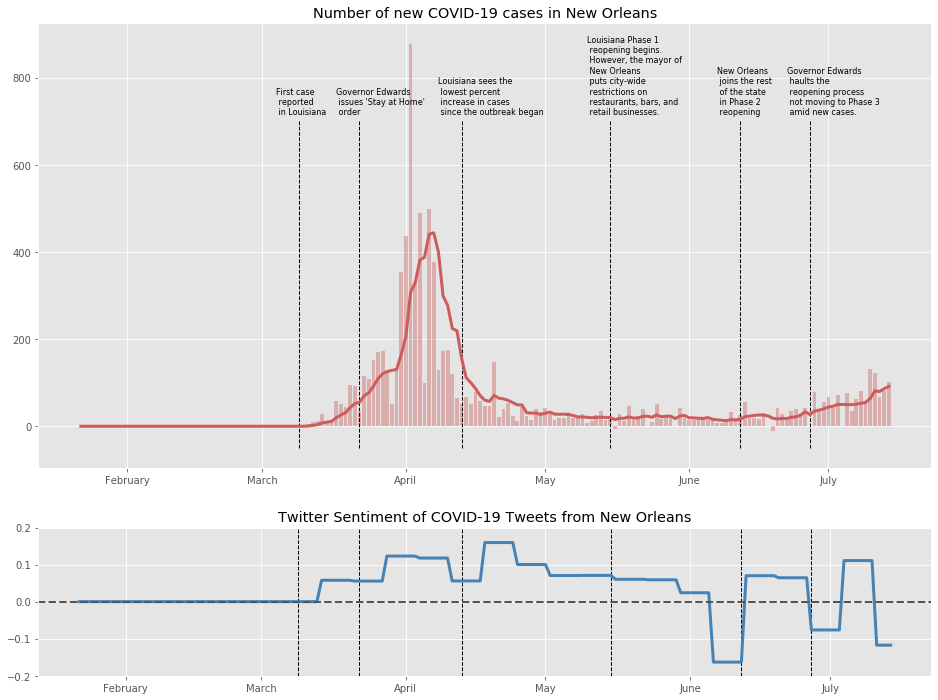

In [21]:
from matplotlib.pyplot import text

#### assigning dimensions of chart
plt.subplots(figsize=(16,12))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%B')

#### creating the covid cases chart
ax1 = plt.subplot(gs[0])
ax1.set_title('Number of new COVID-19 cases in New Orleans')
ax1.bar(fig_df_NO['Date'], fig_df_NO['New_Cases'], color='indianred', alpha=0.4)
ax1.plot(fig_df_NO['Date'], fig_df_NO['Seven_Day_Avg'], c='indianred', linewidth=3)
ax1.vlines(x=important_dates_no, ymin=-50, ymax=700, color='black', linestyle='--', linewidth=1)
plt.gca().xaxis.set_major_formatter(fmt)

#### loading in important dates and events
for i, x in enumerate(important_dates_no):
    text(x-5, 715, important_events_no[i], rotation=0, fontweight=500, size=8)

#### creating the sentiment analysis chart
ax2 = plt.subplot(gs[1])
ax2.set_title('Twitter Sentiment of COVID-19 Tweets from New Orleans')
ax2.plot(fig_df_NO['Date'], fig_df_NO['COMPOUND'], color='steelblue', linewidth=3)
ax2.axhline(linewidth=2, color='#555555', linestyle='--')
ax2.vlines(x=important_dates_no, ymin=-0.2, ymax=2, color='black', linestyle='--', linewidth=1)
ax2.set_ylim([-.2, .2])

plt.gca().xaxis.set_major_formatter(fmt)
plt.style.use('ggplot')

plt.show()

It's interesting to see that drastic changes in weekly sentiment scores tend to follow some of our important events in the state of Louisiana and the city of New Orleans. Although we cannot fully attribute changes in sentiment based on these events, and the analysis we devised potentially misses out on some of the nuance in the views expressed by COVID-19, we can see a few trends. For instance, there seems to be a pretty substantial shift from negative to positive sentiment around the time New Orleans entered Phase 2 opening, and then another substantial shift from positive to negative sentiment around the time of a second wave in New Orleans (from late June into early July). This may indicate that as the state started to progress in its reopening agenda, people's view of COVID-19 tended to be more positive. However, around the time Governor Edwards stopped the progression of re-opening from Phase 2 to Phase 3 across the state, people in the city of New Orleans tended to express more frustration and negativity about the pandemic.

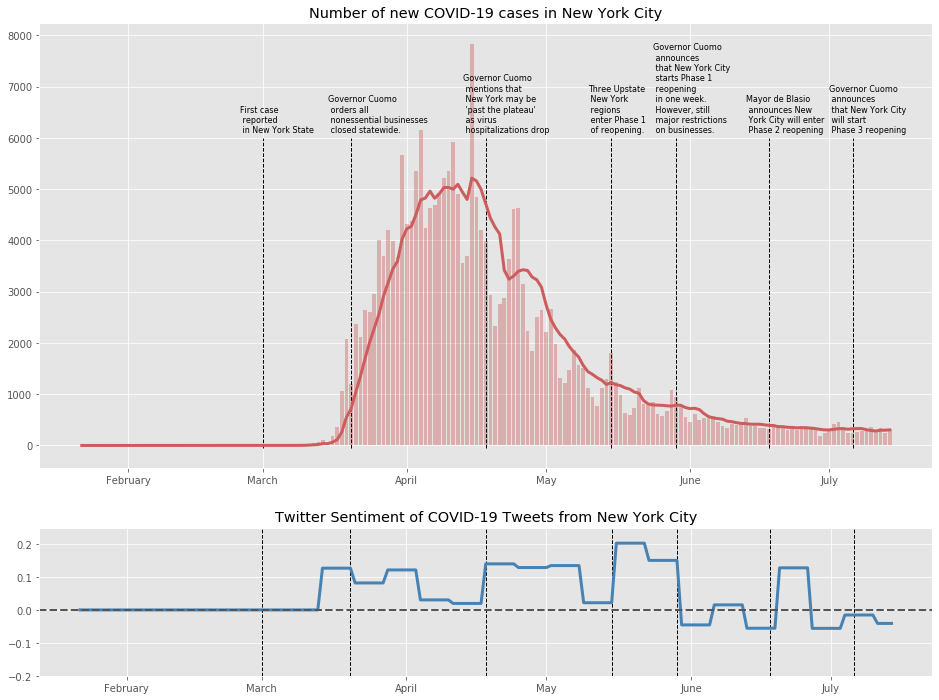

In [20]:
from matplotlib.pyplot import text

#### assigning dimensions of chart
plt.subplots(figsize=(16,12))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

#### creating the covid cases chart
ax1 = plt.subplot(gs[0])
ax1.set_title('Number of new COVID-19 cases in New York City')
ax1.bar(fig_df_NYC['Date'], fig_df_NYC['New_Cases'], color='indianred', alpha=0.4)
ax1.plot(fig_df_NYC['Date'], fig_df_NYC['Seven_Day_Avg'], c='indianred', linewidth=3)
ax1.vlines(x=important_dates_nyc, ymin=-50, ymax=6000, color='black', linestyle='--', linewidth=1)
plt.gca().xaxis.set_major_formatter(fmt)

#### loading in important dates and events
for i, x in enumerate(important_dates_nyc):
    text(x-5, 6100, important_events_nyc[i], rotation=0, fontweight=500, size=8)

#### creating the sentiment analysis chart
ax2 = plt.subplot(gs[1])
ax2.set_title('Twitter Sentiment of COVID-19 Tweets from New York City')
ax2.plot(fig_df_NYC['Date'], fig_df_NYC['COMPOUND'], color='steelblue', linewidth=3)
ax2.axhline(linewidth=2, color='#555555', linestyle='--')
ax2.vlines(x=important_dates_nyc, ymin=-0.2, ymax=2, color='black', linestyle='--', linewidth=1)
ax2.set_ylim([-0.2, 0.25])

plt.gca().xaxis.set_major_formatter(fmt)
plt.style.use('ggplot')

plt.show()

Similar to our graphs for the city of New Orleans, we do start to see a few trends show up with our sentiment analysis as they relate to the number of new daily COVID-19 cases throughout New York City. For instance, sentiment was quite neutral during the time that the pandemic was severely affecting New York City. However, once the daily number of cases started to plateau in mid-April, we do see a pretty substantial shift from neutral to a more positive sentiment in tweets about COVID-19. Additionally, some arguments could be made about shifts in sentiment around the time of announcements of phase changes for reopening the state and city of New York. However, it does appear that as the pandemic continues to drag on longer, the sentiment in tweets from New Yorkers tends to be more negative. We wonder if this is due to people feeling burned out by prolonged vigilance about contractinv the virus, or the toll it is having on families, businesses, or a combination of these factors.

### Network Analysis of Shared Tweet Hashtags about COVID-19
As mentioned in our initial goals, we decided to perform network analysis on Twitter data as a way to identify relationships between major US cities and shared tweet hashtags. In order to do this, we started by isolating twitter data and hashtags by geographic location.

#### Hashtags by Coordinate
First, we'll define two functions that will help to format our hashtag data. The first will be used to split the hashtag column into separate entities and the second will be used to create a final edge list for our network.

In [38]:
############### splitting hashtag groupings
def splitTags(x,y):
    return [(x,z) for z in y]

############### create edge list
def createEdges(ls):    
    productList = []
    
    for i in ls:
        if len(i) >1:
            productList.append(list(combinations(i,2)))
    
    return [val for sublist in productList for val in sublist]

In [39]:
# hashtags & coordinates for each record
hashtags = tweets['HASHTAGS'].tolist()
coords = tweets['COORDS'].tolist()
sepHash = [i.split() for i in hashtags]
sepHash[1:5]

[[], [], [], []]

In [40]:
# set of all coordinates with individual hashtag
coordTag = [splitTags(i,j) for i,j in list(zip(coords,sepHash)) if len(j)> 0]
flattened = [val for sublist in coordTag for val in sublist]
finalHash = set(flattened)

# create a dictionary of each hashtag with the city coordinates
tempDict = {}
for i,j in finalHash:
    if j not in tempDict:
        tempDict[j]= [i]
    else:
        tempDict[j].append(i)
        
# remove covid hashtags from dictionary
tagsToRemove = ['#covid_19', '#COVID19', '#COVID2019', '#COVID_19', '#COVID__19', '#COVID', '#CoronavirusUSA', '#CV19',
                '#COVD19', '#Covid_19', '#CORONAVIRUS', '#Coronavirus', '#CoronavirusCOVID', '#Corona', '#Coronovirus',
               '#CoronavirusOubreak', '#CoronavirusPandemic', '#CoronavirusOutbreak', '#CoronavirusPandemic', '#coronavirus', 
                '#Covid19', '#covid', '#Covid', '#covid19', '#pandemic', '#corona']

for k in tagsToRemove:
    tempDict.pop(k, None)

print('Example output from the hashtag #hoax:')
tempDict['#hoax']

Example output from the hashtag #hoax:


['40.7127837,-74.0059413', '43.661471,-70.2553259', '29.7604267,-95.3698028']

In [42]:
len(tempDict['#VoteBlueToSaveAmerica2020'])
#sorted(tempDict['#BlackLivesMatter'])

#list(set(tempDict['#VoteBlueToSaveAmerica2020']) & set(tempDict['#BlackLivesMatter']))


print('business: ' , len(tempDict['#business']))
print('stay home: ' , len(tempDict['#stayhome']))
print('both: ', len(set(tempDict['#business']) & set(tempDict['#stayhome'])))

business:  12
stay home:  46
both:  12


#### Top Hashtags 
Let's take a look at the hashtags used in the highest number of cities. #WearAMask and #COVIDIOTS in particular stand out. 

In [43]:
# top hashtags
hsh = []
ties = []
for key, value in tempDict.items():
    hsh.append(key)
    ties.append(len(value))
Hash_Ties = pd.DataFrame()
Hash_Ties['Hashtag'] = hsh
Hash_Ties['Cities'] = ties
Hash_Ties = Hash_Ties.sort_values(by=['Cities'],ascending = False)
Hash_Ties.head(10)

,Hashtag,Cities
563,#SocialDistancing,46
1808,#StayHome,46
445,#stayhome,46
538,#socialdistancing,44
154,#CoronaOutbreak,44
1377,#CoronaVirusUpdate,42
936,#quarantine,41
1168,#staysafe,40
284,#lockdown,40
608,#StayAtHome,39


In [44]:
#### Final Edges
# combining all elements in the dictionary values into separate node connections
coordPairs = list(tempDict.values())
finalPairs = createEdges(coordPairs)

print('Example Edge:', finalPairs[1])

Example Edge: ('36.8529263,-75.977985', '39.9611755,-82.9987942')


In [45]:
# split into 2 subnetworks
magaTweets = tempDict['#MAGA']
tindTweets = tempDict['#TrumpIsANationalDisgrace']

#### Visualize Network

Now, with our hashtags isolated by geographic location, and our edges created between shared hashtags between major cities, we can read in our COVID-19 data to further develop node attributes for our network.

In [47]:
city_data = pd.read_csv('covid_cases_citypop.csv')
city_data.head()

,City,State,Long Name,FIPS,Rank,Population,Lat,Long,1/22/2020,1/23/2020,...,7/5/2020,7/6/2020,7/7/2020,7/8/2020,7/9/2020,7/10/2020,7/11/2020,7/12/2020,7/13/2020,7/14/2020
0,New York,New York,"New York, New York, US",36061,1,8405837,40.712784,-74.005941,0,0,...,216969,217216,217488,217777,218052,218403,218710,219051,219301,219616
1,Los Angeles,California,"Los Angeles, California, US",6037,2,3884307,34.052234,-118.243685,0,0,...,115024,116570,120764,123256,124992,127439,130394,133549,136357,140576
2,Chicago,Illinois,"Chicago, Illinois, US",17031,3,2718782,41.878114,-87.629798,0,0,...,92532,92781,93053,93496,94005,94605,95138,95557,95884,96186
3,Houston,Texas,"Houston, Texas, US",48201,4,2195914,29.760427,-95.369803,0,0,...,36597,37776,39311,40012,40918,41999,43939,45368,47369,49027
4,Philadelphia,Pennsylvania,"Philadelphia, Pennsylvania, US",42101,5,1553165,39.952584,-75.165222,0,0,...,26565,26810,26901,26969,27228,27341,27367,27367,27575,27723


Since this dataset has data for each of our major cities linked to geographic coordinates, we iterated over the dataset and added node attributes including: 
+ **position** attribute(based on latitude/longitude coordinates)
+ **population count** attribute
+ **cumulative number of COVID-19 cases (as of 7/14/2020)** attribute 
+ **proportion of cases per population** attribute
+ **region** attribute that separates our nodes based on distinct geographical boundaries

In [48]:
Node = {}

for idx, row in city_data.iterrows():
    city = row['City']
    if city not in Node:
        attr = {}
        lat = row['Lat']
        long = row['Long']
        pop = int(row['Population'])
        
        cases = int(row['7/14/2020'])
        attr['pos'] =  (float(long),float(lat))
        attr['pop'] = int(pop/1000)
        attr['cases'] = int(cases)
        attr['cas_per_pop'] = round(cases/pop,5)
        UEC = ['Maine', 'Vermont','New Hampshire', 'Massachusetts', 'Connecticut', 'Rhode Island', 'New York', 'New Jersey', 'Pennsylvania', 'Maryland', 'Delaware']
        LEC = ['West Virginia', 'Virginia' , 'North Carolina' , 'South Carolina','Georgia', 'Florida']
        MW = ['Ohio', 'Michigan', 'Kentucky', 'Tennessee', 'Indiana','Illinois','Wisconsin','Minnesota','North Dakota','South Dakota','Nebraska','Kansas','Oklahoma','Missouri','Iowa']
        RM = ['Montana','Idaho','Wyoming','Colorado','Utah']
        WC = ['Washington','Oregon','California','Arizona','Nevada','Alaska','Hawaii']
        GC = ['New Mexico', 'Texas', 'Arkansas', 'Louisiana', 'Mississippi', 'Alabama']
        if row['State'] in UEC:
            attr['region'] = (0.8,1,1)
        elif row['State'] in LEC:
            attr['region'] = (1,0.8,0.6)
        elif row['State'] in MW:
            attr['region'] = (0.8,1,0.8)
        elif row['State'] in RM:
            attr['region'] = (1,0.6,0.6)
        elif row['State'] in WC:
            attr['region'] = (1,1,0.6)
        elif row['State'] in GC:
            attr['region'] = (0.6,0.3,0)
        else:
            attr['region'] = 'red'
        
        Node[city] = attr

In [49]:
def coord_to_cities(node):
    split = node.split(',')
    lat = split[0]
    long = split[1]
    lat = round(float(lat),4)
    long = round(float(long),4)
    for idx, row in city_data.iterrows():
        if lat == round(row['Lat'],4) and long == round(row['Long'],4):
            return row['City']

In [50]:
#https://www.geeksforgeeks.org/python-program-to-count-duplicates-in-a-list-of-tuples/
def count(listOfTuple): 
    count_map = {} 
    for i in listOfTuple: 
        count_map[i] = count_map.get(i, 0) +1
    #print(count_map) 
    return count_map
x = count(finalPairs)

In [51]:
w_edges = []
for key, value in x.items():
    w_edges.append(key + (value/10,))

In [34]:
def view_network(edgelist, US = True):
    G = nx.Graph()
    G.add_weighted_edges_from(edgelist)
    node_name_map = {}
    for node in G.nodes:
        city= coord_to_cities(node)
        node_name_map[node] = city
    G = nx.relabel_nodes(G, node_name_map)
    nx.set_node_attributes(G, Node)
    
    if US:
        Gpos=nx.get_node_attributes(G,'pos')
    else:
        Gpos = nx.spring_layout(G)

    Ncol=list(nx.get_node_attributes(G,'region').values())    
    case_per_pop = list(nx.get_node_attributes(G,'cas_per_pop').values())
    cmin, cmax = min(case_per_pop), max(case_per_pop)
    for i, val in enumerate(case_per_pop):
        case_per_pop[i] = ((val-cmin) / (cmax-cmin))*1500

    weights = [G[u][v]['weight'] for u,v in G.edges()]

    plt.figure(1, figsize=(16,12))
    nx.draw_networkx(G, pos = Gpos,node_size = case_per_pop, node_color = Ncol,  edge_color ='grey', with_labels = True, font_size = 12, width = weights)
    
    plt.show()

##### Displaying the network based on U.S. Geographical Coordinates

Below, we decided to initially map our network based on node position mapped to U.S. geographical coordinates. The size of each node displayed is based on the proportion of confirmed COVID-19 cases relative to each city's population size. Additionally, the color of each node is based on regional designations (such as "Upper East Coast", "Lower East Coast", "West Coast", "Midwest", etc.). The thickness of each edge between cities is based on the number of shared secondary hashtags there are between the two locations.

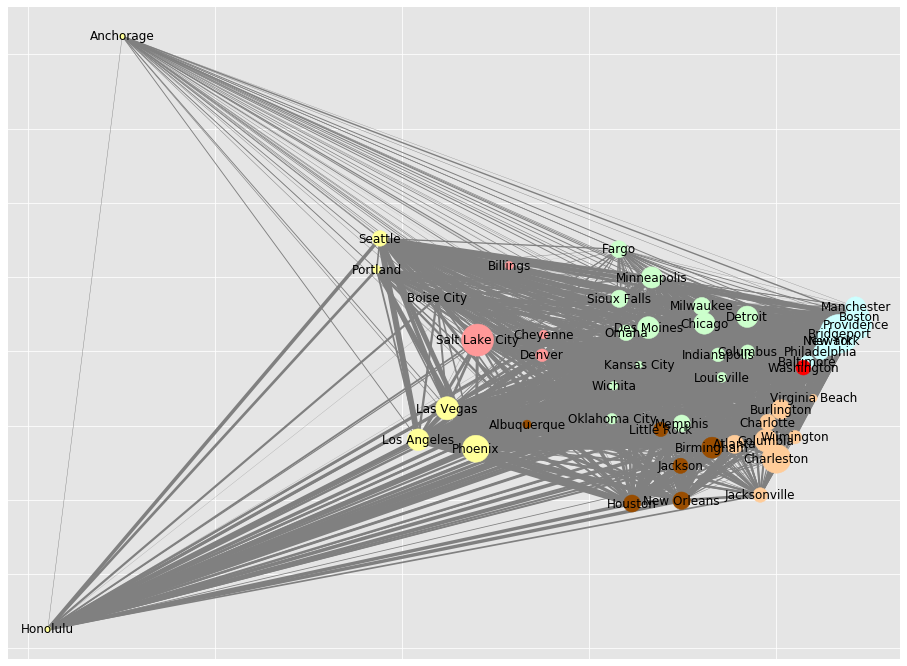

In [35]:
view_network(w_edges)

As we can see above, there's a pretty substantial network of shared hashtags across the different cities. Additionally, we can visibly see based on node size that many cities in the Upper East Coast tend to have a larger proportion of confirmed COVID-19 cases relative to their population sizes. Something we can see play out more in the following network visualization.

##### Displaying the network in a spring layout

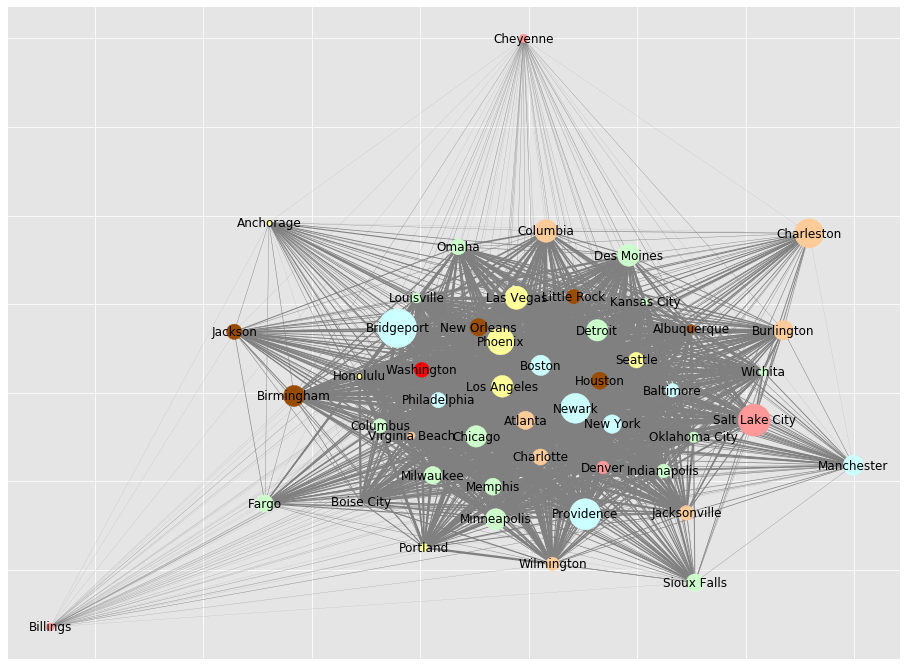

In [36]:
view_network(w_edges, False)

After readjusting the layout of our network of major U.S. cities to match a spring layout, we can start to see cities that tend to be more central in the conversation of tweets and the number of shared hashtags around COVID-19. It's no surprise that many of the Upper East Coast and West Coast cities tend to be more central in our network -- as expected, many of these cities have had high confirmed case counts over the first few months of the pandemic (or experienced a large number of COVID-related deaths) and appear to be more central in their count of shared hashtags. Additionally, it's interesting to see that many midwestern cities, as well as cities that make up much of the Rocky Mountain region, tended to be more on the outskirts of our network. Due to their node size, we can also deduce that they tend to have lower confirmed case counts relative to their population than many of the cities that are more central in the network. This shows that people tweeting from these locations may be less active in the conversation around COVID-19 due to their proximity to the outbreak. Finally, it was interesting to see cities like Charleston and Salt Lake City, both of which appear to have pretty high confirmed cases counts relative to their population, but are less central in the network. We can suspect that people tweeting from these locations may be actively engaging in the COVID-19 narrative, but are circulating additional hashtags that are less common.

### Edge Weights
https://www.geeksforgeeks.org/python-program-to-count-duplicates-in-a-list-of-tuples/